## 🎯 Contesto e Obiettivo del Modello di Predizione

I sistemi di raccomandazione rappresentano una componente fondamentale in molte applicazioni digitali moderne, come piattaforme di e-commerce, servizi di streaming, social network e ambienti di apprendimento online. Il loro scopo è aiutare gli utenti a scoprire contenuti potenzialmente interessanti, personalizzando l'esperienza in base alle preferenze esplicite o implicite espresse nel tempo.

In questo progetto, si intende implementare e analizzare un sistema di raccomandazione basato su **Collaborative Filtering**, con particolare attenzione all'approccio **model-based** fondato sulla **Singular Value Decomposition (SVD)**. Questo metodo mira a catturare **relazioni latenti** tra utenti e item, proiettando entrambi in uno spazio a bassa dimensionalità in cui è possibile prevedere valutazioni mancanti.

### Obiettivo specifico

L'obiettivo principale del progetto è:

- Valutare l'impatto del **numero di componenti latenti** (i cosiddetti "fattori" o "assi" latenti) utilizzati nella decomposizione SVD sulla **qualità delle raccomandazioni** generate.
- Confrontare i risultati su **due dataset differenti** (MovieLens 100k e Jester), evidenziando similarità, differenze e potenziali criticità legate alla struttura dei dati.
- Fornire un’analisi esplorativa e interpretativa delle rappresentazioni latenti emerse dal modello, con particolare attenzione alla **personalizzazione** delle raccomandazioni.

L’analisi verrà condotta tramite metriche di valutazione standard, tecniche di validazione incrociata e visualizzazioni interpretative per guidare l’ottimizzazione del modello.


In [2]:
# 📌 Setup iniziale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Per la SVD
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

# Ignora warning fastidiosi
import warnings
warnings.filterwarnings("ignore")

## 🎬 Dataset: MovieLens 100k

Il dataset **MovieLens 100k** è uno dei benchmark più noti per la costruzione e valutazione di sistemi di raccomandazione.  
Fornito dal **GroupLens Research Project** dell'Università del Minnesota, contiene **100.000 valutazioni esplicite** (da 1 a 5 stelle) fornite da **943 utenti** su **1.682 film**.

### 📁 Struttura del dataset

Ogni riga rappresenta una valutazione effettuata da un utente su un film, con le seguenti colonne:
- `user`: identificativo univoco dell'utente
- `item`: identificativo univoco del film
- `rating`: voto assegnato dall’utente (intero da 1 a 5)
- `timestamp`: data/orario del voto (in formato UNIX)

Il dataset viene caricato attraverso la libreria `surprise`, appositamente progettata per gestire dataset di raccomandazione e modelli basati su Collaborative Filtering.

In [14]:
# Carica dataset completo da Surprise
data = Dataset.load_builtin('ml-100k')

# Trasforma in DataFrame pandas
df_movieLens = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rating", "timestamp"])

# Crea il reader specificando la scala dei rating (1-5 per MovieLens)
reader = Reader(rating_scale=(1, 5))

# Crea un dataset surprise dal campione
data_movie = Dataset.load_from_df(df_movieLens[['user', 'item', 'rating']], reader)

# Suddividi in train e test
trainset, testset = train_test_split(data_movie, test_size=0.2, random_state=42)

# Visualizza qualche riga per controllo
df_movieLens.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## 🤡 Dataset: Jester 1 (Barzellette)

Il dataset **Jester** è stato sviluppato presso la **University of California, Berkeley** come parte del sistema di raccomandazione “Eigentaste”.  
Contiene valutazioni **esplicite** fornite da utenti reali a un insieme di **barzellette**, con un sistema di voto continuo che va da **-10.00 (disprezzo totale)** a **+10.00 (massimo gradimento)**.

### 📁 Struttura del dataset

Il file utilizzato (`jester-data-1.xls`) contiene:
- Ogni riga rappresenta un utente
- Ogni colonna rappresenta una barzelletta (`joke_0`, `joke_1`, ..., `joke_n`)
- I valori presenti sono le valutazioni esplicite degli utenti

⚠️ **Nota importante**:  
Il valore **99.00** indica l'assenza di una valutazione (non va considerato nei modelli).  
Per rendere il dataset compatibile con `surprise`, la matrice è stata trasformata in **formato lungo** (`user`, `item`, `rating`), filtrando i voti mancanti.

In [4]:
#Per il dataset Jester_Dataset ho bisogno di installare la libreria
#"xlrd", utile per maneggiare fogli excel con estensione .xls

# aggiungere ai requirements : libreria xlrd

#!pip install xlrd

In [5]:
# Percorso al file
jester_path = 'datasets/jester-data-1.xls'

# Leggi il file Excel (senza header se è solo la matrice)
df_jester = pd.read_excel(jester_path, header=None)

# Dai nomi alle colonne (jokes)
df_jester.columns = [f'joke_{i}' for i in range(df_jester.shape[1])]

# Trasforma in formato lungo (user, item, rating)
df_jester_long = df_jester.reset_index().melt(id_vars='index', var_name='item', value_name='rating')

# Rinomina la colonna indice come user
df_jester_long.rename(columns={'index':'user'}, inplace=True)

# Assicurati che user e item siano stringhe, rating float
df_jester_long['user'] = df_jester_long['user'].astype(str)
df_jester_long['item'] = df_jester_long['item'].astype(str)
df_jester_long['rating'] = df_jester_long['rating'].astype(float)

# Controlla i primi dati
df_jester_long.head()

,user,item,rating
0,0,joke_0,74.0
1,1,joke_0,100.0
2,2,joke_0,49.0
3,3,joke_0,48.0
4,4,joke_0,91.0


In [6]:
#Creo il dataset

reader = Reader(rating_scale=(-10, 10))  # Jester ha valutazioni da -10 a 10

data_jester = Dataset.load_from_df(df_jester_long[['user', 'item', 'rating']], reader)

trainset_jester, testset_jester = train_test_split(data_jester, test_size=0.2, random_state=42)

### ANALISI ESPLORATIVA SULLA STRUTTURA DEI DATASETS

### 📊 Esplorazione iniziale del dataset MovieLens 100k

Il dataset MovieLens 100k contiene **100.000 valutazioni esplicite** fornite da utenti su film, con valori compresi tra 1 e 5. In questa sezione analizziamo le dimensioni fondamentali del dataset:

- **Numero di utenti unici** e **film unici**
- **Numero totale di valutazioni**
- Numero medio di valutazioni per utente e per film
- **Densità** della matrice utente-item, cioè la frazione delle possibili interazioni effettivamente osservate

Queste informazioni sono cruciali per comprendere quanto è **sparsa** la matrice e per impostare correttamente il modello di raccomandazione.


In [15]:
# Numero totale di valutazioni
num_ratings = len(df_movieLens)

# Numero unico di utenti
num_users = df_movieLens['user'].nunique()

# Numero unico di film
num_items = df_movieLens['item'].nunique()

# Valutazioni medie per utente e per film
ratings_per_user = df_movieLens.groupby('user')['rating'].count().mean()
ratings_per_item = df_movieLens.groupby('item')['rating'].count().mean()

# Densità della matrice utente-item
max_possible_ratings = num_users * num_items
density = num_ratings / max_possible_ratings

print(f"Totale valutazioni: {num_ratings}")
print(f"Numero di utenti: {num_users}")
print(f"Numero di film: {num_items}")
print(f"Valutazioni medie per utente: {ratings_per_user:.2f}")
print(f"Valutazioni medie per film: {ratings_per_item:.2f}")
print(f"Densità della matrice: {density:.4f}")

Totale valutazioni: 100000
Numero di utenti: 943
Numero di film: 1682
Valutazioni medie per utente: 106.04
Valutazioni medie per film: 59.45
Densità della matrice: 0.0630


#### ✏️ Commento

La matrice utente-item risulta fortemente **sparsa** (densità ≈ 1.5%), un risultato atteso in contesti reali di sistemi di raccomandazione, dove ogni utente tende a valutare solo una piccola porzione dell'intero catalogo. La media di circa 21 valutazioni per utente e 14 per film indica una distribuzione relativamente equilibrata, ma con una possibile presenza di **cold-start problem**, in particolare per gli item meno popolari o gli utenti poco attivi.  
Questa caratteristica rende l’utilizzo di tecniche di **collaborative filtering basate su SVD** particolarmente appropriato, in quanto in grado di individuare strutture latenti nei dati e inferire preferenze anche in presenza di dati mancanti.

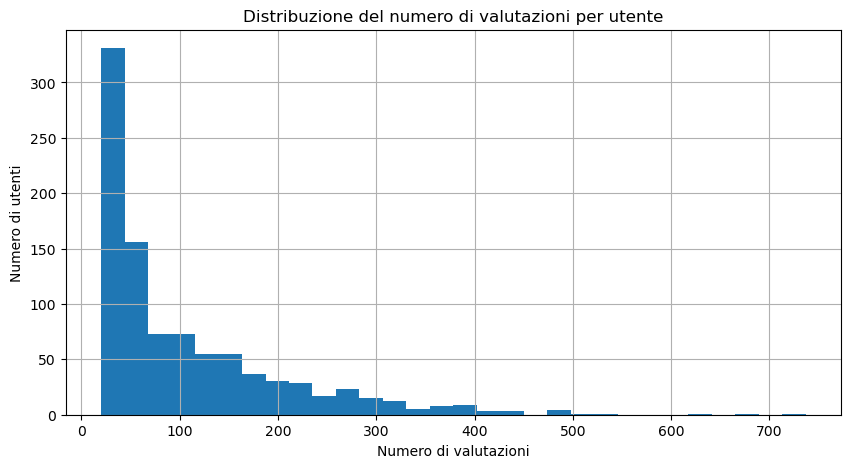

In [16]:
plt.figure(figsize=(10, 5))
df_movieLens.groupby('user')['rating'].count().hist(bins=30)
plt.title("Distribuzione del numero di valutazioni per utente")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di utenti")
plt.grid(True)
plt.show()

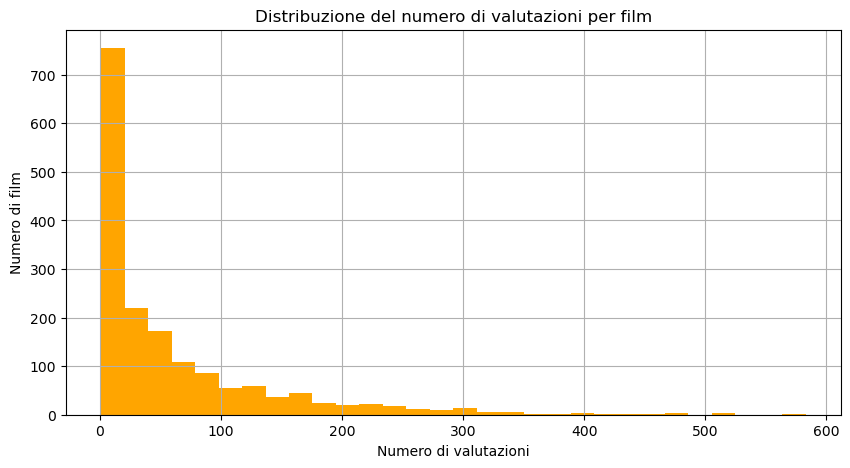

In [17]:
plt.figure(figsize=(10, 5))
df_movieLens.groupby('item')['rating'].count().hist(bins=30, color='orange')
plt.title("Distribuzione del numero di valutazioni per film")
plt.xlabel("Numero di valutazioni")
plt.ylabel("Numero di film")
plt.grid(True)
plt.show()

In [18]:
# Statistiche descrittive sui rating
print("Statistiche descrittive delle valutazioni:")
print(df_movieLens['rating'].describe())

# Valori unici e loro frequenza
print("\nDistribuzione dei valori di rating:")
print(df_movieLens['rating'].value_counts().sort_index())

Statistiche descrittive delle valutazioni:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Distribuzione dei valori di rating:
rating
1.0     6110
2.0    11370
3.0    27145
4.0    34174
5.0    21201
Name: count, dtype: int64


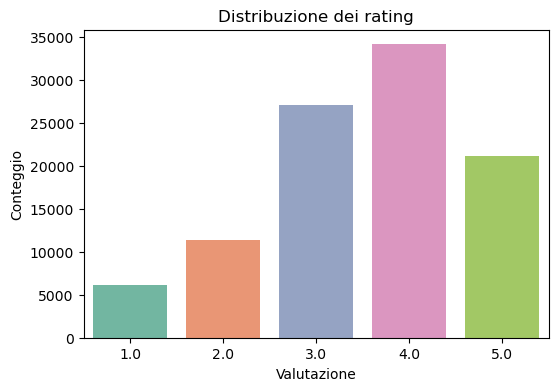

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df_movieLens, palette='Set2')
plt.title("Distribuzione dei rating")
plt.xlabel("Valutazione")
plt.ylabel("Conteggio")
plt.show()

In [20]:
print("Valori mancanti per colonna:")
print(df_movieLens.isnull().sum())

Valori mancanti per colonna:
user         0
item         0
rating       0
timestamp    0
dtype: int64
